# Deep learning


### Objectives

* Using deep learning approach to the RNA dataset  


### Description of datasets

* The patient info dataset contains demographic (age, sex, race, years of education, etc.) and diagnostic (dementia vs. no dementia) information for 107 unique patients 
* The protein and neuropathology dataset contains expression of 29 proteins from 4 different regions of the brain. For each patient, there are 29X4=116 features.


### Explantion of the original study and data

The  Adult Changes in Thought (ACT) study is a population-based study of brain aging and incident dementia, conducted by Kaiser Permanente Washington Health Research Institute. A specific part of this study, the Aging, Dementia, and Traumatic Brain Injury Study, contains detailed neuropathologic (protein expression) and transcriptomic (RNA expression) characterization of brains from a unique cohort with demographic matched dementia and non-dementia patients. The original aim of the Aging, Dementia, and TBI Study was to study neuropathologic and molecular signatures as a result of severity of TBI. However, the availability of extensive protein and RNA data can potentially be used to identify molecular hallmarks of and to ultimately predict the likelihood of developing dementia. 

* http://aging.brain-map.org/overview/home
* https://help.brain-map.org/display/aging/Documentation

Date 04/21/2022

## Data Preparation

In [1]:
#import libaries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

DonorInformation      = pd.read_csv("data/DonorInformation.csv")
DescriptionOfStains   = pd.read_csv("data/DescriptionOfStains.csv")
fpkm_table_normalized = pd.read_csv("data/fpkm_table_normalized.csv")
columns_samples       = pd.read_csv("data/columns-samples.csv")

In [2]:
#taking Yin li's data cleaning for the donor info
donor_df=DonorInformation

#Change donor age to numeric 
donor_df.loc[donor_df["age"] == "95-99", "age"] = '98'
donor_df.loc[donor_df["age"] == "90-94", "age"] = '92'
donor_df.loc[donor_df["age"] == "100+", "age"] = '100'
donor_df['age']=donor_df['age'].astype('int64')

#Change nincds_arda_diagnosis to numeric
conditions = [
    (donor_df['nincds_arda_diagnosis'] == 'No Dementia'),
    (donor_df['nincds_arda_diagnosis'] == "Probable Alzheimer'S Disease"),
    (donor_df['nincds_arda_diagnosis'] == "Possible Alzheimer'S Disease"),
    (donor_df['nincds_arda_diagnosis'] == "Dementia, Type Unknown")
]

values = [0, 1, 2, 3]

donor_df['nincds_arda_diagnosis_n'] = np.select(conditions, values)
donor_df['nincds_arda_diagnosis'] = donor_df['nincds_arda_diagnosis_n']
donor_df=donor_df.drop(columns=['nincds_arda_diagnosis_n'])


#Change sex to numeric
donor_df['sex'] = np.where(donor_df['sex']=='M', 0, 1)
donor_df['tbi'] = np.where(donor_df['ever_tbi_w_loc']=='Y', 0, 1)

#Change act_demented to numeric
donor_df['act_demented'] = np.where(donor_df['act_demented']=='No Dementia', 0, 1)

print('donor_df shape:', donor_df.shape)
print('donor ages:',donor_df['age'].unique())
print('donor nincds_arda_diagnosis:',donor_df['nincds_arda_diagnosis'].unique())
print('donor sexes:',donor_df['sex'].unique())
print('donor TBI:',donor_df['tbi'].unique())
print('donor act_demented:',donor_df['act_demented'].unique())

donor_df shape: (107, 20)
donor ages: [ 87  98  85  92 100  89  78  83  82  77  81  88  84  86  79]
donor nincds_arda_diagnosis: [0 3 2 1]
donor sexes: [0 1]
donor TBI: [1 0]
donor act_demented: [0 1]


In [3]:
donor_df

donor_id        name  age  sex apo_e4_allele  education_years  \
0    326765665  H14.09.078   87    0             N               16   
1    326765656  H14.09.069   98    0             N               17   
2    326765654  H14.09.067   85    0             Y               10   
3    467056391  H15.09.103   92    1             N               11   
4    309335447  H14.09.010  100    0             Y               16   
..         ...         ...  ...  ...           ...              ...   
102  309335458  H14.09.021   88    0             N               12   
103  309335462  H14.09.025   84    0             N               16   
104  309335454  H14.09.017   79    0             N               16   
105  309335486  H14.09.049   98    0             N               21   
106  309335442  H14.09.005   92    1             Y               14   

     age_at_first_tbi longest_loc_duration  cerad  num_tbi_w_loc  \
0                   0       Unknown or N/A      0              0   
1                  12              1-2 min      2              1   
2                  72             < 10 sec      3              1   
3                  87             < 10 sec      0              1   
4                   0       Unknown or N/A      3              0   
..                ...                  ...    ...            ...   
102                18               > 1 hr      0              1   
103                23        10 min - 1 hr      0              2   
104                13             < 10 sec      2              3   
105                18              3-5 min      1              1   
106                 3       Unknown or N/A      1              2   

    dsm_iv_clinical_diagnosis  control_set  nincds_arda_diagnosis  \
0                 No Dementia           31                      0   
1                 No Dementia           26                      0   
2                    Vascular           25                      3   
3                 No Dementia           52                      0   
4    Alzheimer's Disease Type           28                      2   
..                        ...          ...                    ...   
102  Alzheimer's Disease Type           21                      1   
103  Alzheimer's Disease Type           40                      1   
104               No Dementia           44                      0   
105               No Dementia           12                      0   
106       Multiple Etiologies           16                      2   

    ever_tbi_w_loc   race      hispanic  act_demented  braak  nia_reagan  tbi  
0                N  White  Not Hispanic             0      1           1    1  
1                Y  White  Not Hispanic             0      5           2    0  
2                Y  White  Not Hispanic             1      4           2    0  
3                Y  White  Not Hispanic             0      4           0    0  
4                N  White  Not Hispanic             1      4           2    1  
..             ...    ...           ...           ...    ...         ...  ...  
102              Y  White  Not Hispanic             1      1           1    0  
103              Y  White  Not Hispanic             1      0           0    0  
104              Y  White  Not Hispanic             0      3           2    0  
105              Y  White  Not Hispanic             0      3           1    0  
106              Y  White  Not Hispanic             1      5           2    0  

[107 rows x 20 columns]

In [4]:
##removing items not reaaly useful

removal_lis_p=[#unwanted item in DonorInformation         
'dsm_iv_clinical_diagnosis',#diagnosis persumablely from two different authrity
'nincds_arda_diagnosis',#diagnosis persumablely from two different authrity
'ever_tbi_w_loc',
'name',#anmoyous names with the format H14.09.078, should be excluded.
'longest_loc_duration',#- the majority entries are N/A
'race',#mostly white, only 2 non-white, not sure the usufulness
'hispanic',#all sample are hispanic. thus remove
'apo_e4_allele',
'control_set',
'braak',
'nia_reagan',
'num_tbi_w_loc',
'cerad']

In [5]:
donor_df.drop(columns=removal_lis_p,inplace=True)
donor_df

donor_id  age  sex  education_years  age_at_first_tbi  act_demented  tbi
0    326765665   87    0               16                 0             0    1
1    326765656   98    0               17                12             0    0
2    326765654   85    0               10                72             1    0
3    467056391   92    1               11                87             0    0
4    309335447  100    0               16                 0             1    1
..         ...  ...  ...              ...               ...           ...  ...
102  309335458   88    0               12                18             1    0
103  309335462   84    0               16                23             1    0
104  309335454   79    0               16                13             0    0
105  309335486   98    0               21                18             0    0
106  309335442   92    1               14                 3             1    0

[107 rows x 7 columns]

In [6]:
# com[0].transpose().to_excel("output.xlsx")/
removal_lis_com=[

#unwanted items in fpkm_table_normalized
'rnaseq_profile_id',
'donor_name',
'specimen_id',
'specimen_name',
'rna_well_id',
'polygon_id',
'structure_id',
'structure_acronym',
'structure_color',
'structure_name',
'hemisphere',
'index',]


In [7]:
## Combining donnor's infomation with their respective rna sequence
# column samples, breaking into 4 parts 
structure=list(columns_samples['structure_acronym'].unique())
df=[columns_samples[columns_samples['structure_acronym']==i] for i in structure]

#merging both datasets
merged_per_str=[pd.merge(donor_df, i, 
                         how='left', left_on='donor_id'
                         ,right_on='donor_id').dropna() for i in df]


rna=fpkm_table_normalized.set_index('gene_id \ rnaseq_profile_id').transpose().reset_index()
rna['index']=rna['index'].astype('float64')
# merging againg with the rna sequence
com=[pd.merge(i,rna, how='left', left_on='rnaseq_profile_id',
              right_on='index').drop(columns=removal_lis_com) for i in merged_per_str]

# this now finally give us 4 sets of combined data from 
com[0]

donor_id  age  sex  education_years  age_at_first_tbi  act_demented  tbi  \
0   326765665   87    0               16                 0             0    1   
1   326765656   98    0               17                12             0    0   
2   326765654   85    0               10                72             1    0   
3   467056391   92    1               11                87             0    0   
4   309335447  100    0               16                 0             1    1   
..        ...  ...  ...              ...               ...           ...  ...   
94  309335453   81    0               21                 0             0    1   
95  309335458   88    0               12                18             1    0   
96  309335462   84    0               16                23             1    0   
97  309335454   79    0               16                13             0    0   
98  309335486   98    0               21                18             0    0   

    499304660  499304661  499304662  ...   499355054  499355055  499355056  \
0    0.000000   3.412149        0.0  ...  119.700688        0.0        0.0   
1    0.000000   6.415714        0.0  ...  622.003219        0.0        0.0   
2    0.000000   4.992073        0.0  ...  423.921258        0.0        0.0   
3    0.000000   5.664388        0.0  ...  650.289541        0.0        0.0   
4    0.063323   3.788815        0.0  ...  938.306469        0.0        0.0   
..        ...        ...        ...  ...         ...        ...        ...   
94   0.424591   8.712326        0.0  ...  482.652178        0.0        0.0   
95   0.000000   7.947488        0.0  ...  646.132480        0.0        0.0   
96   0.000000   2.909033        0.0  ...  421.966376        0.0        0.0   
97   0.000000   3.429327        0.0  ...  356.403069        0.0        0.0   
98   0.000000   6.490710        0.0  ...  407.205085        0.0        0.0   

    499355057   499355058  499355059  499355060    499355061  499355062  \
0         0.0   40.775630  12.152382   0.000000   170.107027        0.0   
1         0.0  309.950649  81.856908   0.000000   599.387739        0.0   
2         0.0  209.045769  56.519412   0.000000   461.192751        0.0   
3         0.0  294.207355  70.488572   0.000000   554.106124        0.0   
4         0.0  440.359441  89.619623   1.652072  1077.198174        0.0   
..        ...         ...        ...        ...          ...        ...   
94        0.0  211.664088  51.085650   0.000000   491.317234        0.0   
95        0.0  277.491444  66.261670   0.000000   540.270444        0.0   
96        0.0  208.454369  55.132696   0.000000   440.635065        0.0   
97        0.0  137.534071  41.039696   0.000000   387.094018        0.0   
98        0.0  179.712082  50.113916   5.859007   392.612548        0.0   

    499355063  
0    0.000000  
1    5.877094  
2    0.000000  
3    0.000000  
4    0.000000  
..        ...  
94   6.495066  
95   5.704699  
96   3.883367  
97   0.000000  
98   0.000000  

[99 rows x 50288 columns]

# Because we have combined two dataset, it is nesseary to standardise the dataset

In [8]:
TCx =com[0]
FWM =com[1]
HIP =com[2]
PCx =com[3]

In [9]:
Scaler=StandardScaler()
X1 = Scaler.fit_transform(TCx.set_index('donor_id').to_numpy())
X2 = Scaler.fit_transform(FWM.set_index('donor_id').to_numpy())
X3 = Scaler.fit_transform(HIP.set_index('donor_id').to_numpy())
X4 = Scaler.fit_transform(PCx.set_index('donor_id').to_numpy())

In [10]:
encoder=LabelEncoder()
y1=encoder.fit_transform(TCx['act_demented'].to_numpy())
y2=encoder.fit_transform(FWM['act_demented'].to_numpy())
y3=encoder.fit_transform(HIP['act_demented'].to_numpy())
y4=encoder.fit_transform(PCx['act_demented'].to_numpy())

# Keras

In [11]:
# import keras module with its wrapper for sklearn
from keras.models import Sequential
from keras.layers import Dense,Dropout
from scikeras.wrappers import KerasClassifier, KerasRegressor

# import sklearn packages
from sklearn.model_selection import cross_validate,cross_val_score, GridSearchCV,StratifiedKFold

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
# from tensorflow.keras.callbacks import ModelCheckpoint

from numpy.random import seed
seed(7)
#important to use tf.random.set_seed(), otherwise your nerual network model 
# would give differenet results each time
import tensorflow as tf 
tf.random.set_seed(7)

## Define Models 

In [12]:
def create_baseline():
    model = Sequential()
    model.add(Dense(60,input_dim=X1.shape[1],activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

def create_baseline_with_drop_out():
    model = Sequential()
    model.add(Dense(60,input_dim=X1.shape[1],activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1,activation='sigmoid'))
    
    #compile model
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

# More networks

In [13]:

def mlp3():
    model = Sequential()
    model.add(Dense(60,input_dim=X1.shape[1],activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(30,activation='relu'))
    model.add(Dense(40,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(4,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [14]:
def mlp4():
    model = Sequential()
    model.add(Dense(600,input_dim=X1.shape[1],activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(30,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

# model evulation 

In [15]:
def evaulation(model,X,y):
    
    model.fit(X,y,validation_split=0.20,epochs=200,batch_size=5,verbose=0)
    model.evaluate(X,y)
    return model


In [16]:
model = create_baseline()
model.summary()
evaulation(model,X1,y1)
evaulation(model,X2,y2)
evaulation(model,X3,y3)
evaulation(model,X4,y4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                3017280   
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 3,017,341
Trainable params: 3,017,341
Non-trainable params: 0
_________________________________________________________________


2022-04-24 18:02:05.660520: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3/3 [==============================] - 0s 3ms/step - loss: 3.8295 - accuracy: 0.9231


In [17]:
d={ "TCx":[ 0.9495, 1.3820],
    "FWM":[ 0.8925, 18.9197],
    "HIP":[ 0.9255, 6.3905],
    "PCx":[ 0.9231, 3.8295],
    }
pd.DataFrame(data=d,index=['accuracy','loss']).T

accuracy     loss
TCx    0.9495   1.3820
FWM    0.8925  18.9197
HIP    0.9255   6.3905
PCx    0.9231   3.8295

In [18]:
model = create_baseline_with_drop_out()
model.summary()
evaulation(model,X1,y1)
evaulation(model,X2,y2)
evaulation(model,X3,y3)
evaulation(model,X4,y4)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 60)                3017280   
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 61        
                                                                 
Total params: 3,017,341
Trainable params: 3,017,341
Non-trainable params: 0
_________________________________________________________________
3/3 [==============================] - 0s 3ms/step - loss: 7.6859 - accuracy: 0.9341


In [19]:
d={ "TCx":[ 0.9293, 2.8527],
    "FWM":[ 0.9140, 17.3355],
    "HIP":[ 0.9255, 7.6612],
    "PCx":[ 0.9341, 7.6859],
    }
pd.DataFrame(data=d,index=['accuracy','loss']).T

accuracy     loss
TCx    0.9293   2.8527
FWM    0.9140  17.3355
HIP    0.9255   7.6612
PCx    0.9341   7.6859

In [20]:
model = mlp3()
model.summary()
evaulation(model,X1,y1)
evaulation(model,X2,y2)
evaulation(model,X3,y3)
evaulation(model,X4,y4)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 60)                3017280   
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_5 (Dense)             (None, 30)                1830      
                                                                 
 dense_6 (Dense)             (None, 40)                1240      
                                                                 
 dense_7 (Dense)             (None, 10)                410       
                                                                 
 dense_8 (Dense)             (None, 4)                 44        
                                                                 
 dense_9 (Dense)             (None, 1)                

In [21]:
d={ "TCx":[ 0.9293, 0.5922],
    "FWM":[ 0.9032, 1.1232],
    "HIP":[ 0.9787, 0.2047],
    "PCx":[ 0.9451, 0.2021],
    }
pd.DataFrame(data=d,index=['accuracy','loss']).T

accuracy    loss
TCx    0.9293  0.5922
FWM    0.9032  1.1232
HIP    0.9787  0.2047
PCx    0.9451  0.2021

In [22]:
model = mlp4()
model.summary()
evaulation(model,X1,y1)
evaulation(model,X2,y2)
evaulation(model,X3,y3)
evaulation(model,X4,y4)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 600)               30172800  
                                                                 
 dropout_2 (Dropout)         (None, 600)               0         
                                                                 
 dense_11 (Dense)            (None, 30)                18030     
                                                                 
 dense_12 (Dense)            (None, 10)                310       
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                                 
Total params: 30,191,151
Trainable params: 30,191,151
Non-trainable params: 0
_________________________________________________________________
3/3 [==============================] - 0s 

In [23]:
d={ "TCx":[ 0.9495, 0.5005],
    "FWM":[ 0.9032, 2.4368],
    "HIP":[ 0.8830, 0.2482],
    "PCx":[ 0.8681, 0.3934],
    }
pd.DataFrame(data=d,index=['accuracy','loss']).T

accuracy    loss
TCx    0.9495  0.5005
FWM    0.9032  2.4368
HIP    0.8830  0.2482
PCx    0.8681  0.3934

## Cross validation 

This is a costly operation, mlp4 fails to run using my hardwere.

In [24]:
def kford(model,n_splits,X,y):
    estimater=[]
    estimater.append(('mlp', KerasClassifier(model=model, epochs=200, batch_size=5, verbose=0)))
    pipeline = Pipeline(estimater)
    kford=StratifiedKFold(n_splits=n_splits,shuffle=True)

    results = cross_val_score (pipeline,X,y,cv=kford)
    print("Larger:%.2f%% (%.2f%%)" %(results.mean()*100,results.std()*100))
    return None


In [25]:
# model = create_baseline()
# kford(model,10,X1,y1)
# kford(model,10,X2,y2)
# kford(model,10,X3,y3)
# kford(model,10,X4,y4)

In [26]:
# model = create_baseline_with_drop_out()

# kford(model,10,X1,y1)
# kford(model,10,X2,y2)
# kford(model,10,X3,y3)
# kford(model,10,X4,y4)

In [27]:
# model = mlp3()

# kford(model,10,X1,y1)
# kford(model,10,X2,y2)
# kford(model,10,X3,y3)
# kford(model,10,X4,y4)

In [28]:
# model = mlp4()

# kford(model,10,X1,y1)
# kford(model,10,X2,y2)
# kford(model,10,X3,y3)
# kford(model,10,X4,y4)

# plot network history

In [29]:
#     ploting trainin history
def plot_history(model,X,y):
     
    history=model.fit(X,y,validation_split=0.20,epochs=200,batch_size=5,verbose=0)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()
    
    #model loss plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'],loc='upper left')
    plt.show()
    
    return None


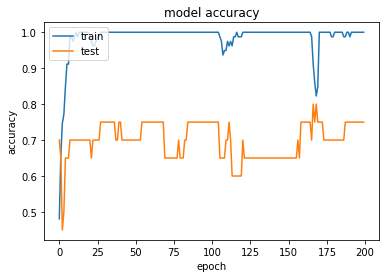

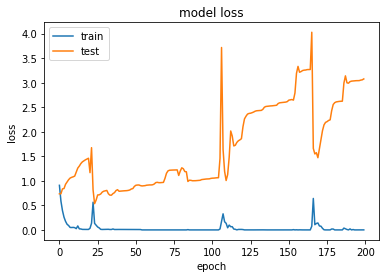

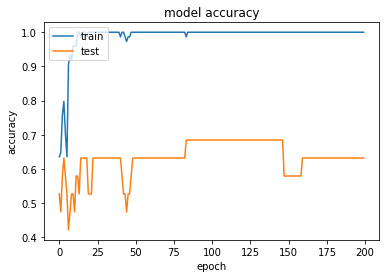

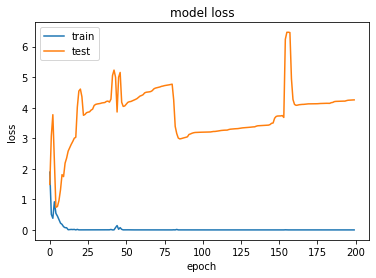

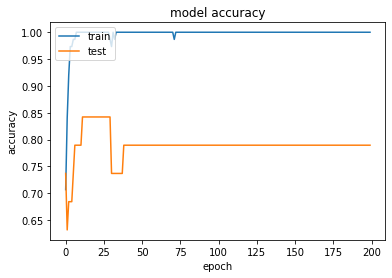

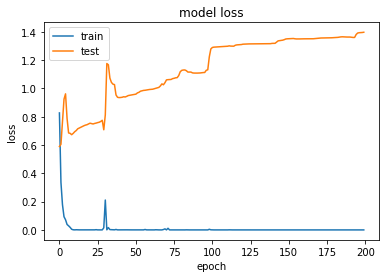

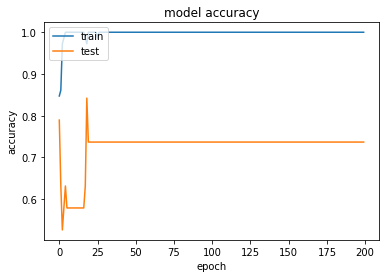

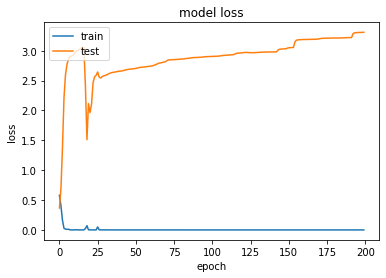

In [30]:
model=mlp3()
plot_history(model,X1,y1)
plot_history(model,X2,y2)
plot_history(model,X3,y3)
plot_history(model,X4,y4)

# Save our best model

In [31]:
def save_model(model,name):
    model_json = model.to_json()
#     model_yaml = model.to_yaml()
    # model.to_json only saves the model architecture,(excluding the model weights and its 
    # configuration)
    with open(f"saved_model/{name}.json","w") as json_file:
        json_file.write(model_json)
    # saving the model weights
    model.save(f"saved_model/{name}.h5")
    print("saved model to disk")

In [32]:
save_model(model,"mlp3")

saved model to disk


# Nerual network Visualise

A useful lib for visulaising nerual networks. because our input dimension is large(52000+), it has diffculity processing, a trick to it is to rewritre the nerual networks without the first layer. 

In [33]:
# !pip install ann_visualizer
# !pip install graphviz

In [34]:

# def mlp3():
#     model = Sequential()
#     model.add(Dense(60,input_dim=100,activation='relu'))
#     model.add(Dropout(0.1))
#     model.add(Dense(30,activation='relu'))
#     model.add(Dense(40,activation='relu'))
#     model.add(Dense(10,activation='relu'))
#     model.add(Dense(4,activation='relu'))
#     model.add(Dense(1,activation='sigmoid'))
#     model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#     return model

In [35]:
# new_model=mlp3()

In [36]:
# def mlp4():
#     model = Sequential()
#     model.add(Dense(600,input_dim=X1.shape[1],activation='relu'))
#     model.add(Dropout(0.1))
#     model.add(Dense(30,activation='relu'))
#     model.add(Dense(10,activation='relu'))
#     model.add(Dense(1,activation='sigmoid'))
#     model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#     return model

In [37]:
# new_model=mlp4()

In [38]:
# from ann_visualizer.visualize import ann_viz;

# ann_viz(new_model, title="My first neural network")

## 1-d CNN using pytorch

In [39]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

import torch
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping



# needed for deterministic output
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

# device in which the model will be trained
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [40]:
# the function here is a taken directly from the author 


class SoftOrdering1DCNN(pl.LightningModule):

    def __init__(self, input_dim, output_dim, sign_size=32, cha_input=16, cha_hidden=32, 
                 K=2, dropout_input=0.2, dropout_hidden=0.2, dropout_output=0.2):
        super().__init__()

        hidden_size = sign_size*cha_input
        sign_size1 = sign_size
        sign_size2 = sign_size//2
        output_size = (sign_size//4) * cha_hidden

        self.hidden_size = hidden_size
        self.cha_input = cha_input
        self.cha_hidden = cha_hidden
        self.K = K
        self.sign_size1 = sign_size1
        self.sign_size2 = sign_size2
        self.output_size = output_size
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output

        self.batch_norm1 = nn.BatchNorm1d(input_dim)
        self.dropout1 = nn.Dropout(dropout_input)
        dense1 = nn.Linear(input_dim, hidden_size, bias=False)
        self.dense1 = nn.utils.weight_norm(dense1)

        # 1st conv layer
        self.batch_norm_c1 = nn.BatchNorm1d(cha_input)
        conv1 = conv1 = nn.Conv1d(
            cha_input, 
            cha_input*K, 
            kernel_size=5, 
            stride = 1, 
            padding=2,  
            groups=cha_input, 
            bias=False)
        self.conv1 = nn.utils.weight_norm(conv1, dim=None)

        self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size = sign_size2)

        # 2nd conv layer
        self.batch_norm_c2 = nn.BatchNorm1d(cha_input*K)
        self.dropout_c2 = nn.Dropout(dropout_hidden)
        conv2 = nn.Conv1d(
            cha_input*K, 
            cha_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv2 = nn.utils.weight_norm(conv2, dim=None)

        # 3rd conv layer
        self.batch_norm_c3 = nn.BatchNorm1d(cha_hidden)
        self.dropout_c3 = nn.Dropout(dropout_hidden)
        conv3 = nn.Conv1d(
            cha_hidden, 
            cha_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv3 = nn.utils.weight_norm(conv3, dim=None)
        

        # 4th conv layer
        self.batch_norm_c4 = nn.BatchNorm1d(cha_hidden)
        conv4 = nn.Conv1d(
            cha_hidden, 
            cha_hidden, 
            kernel_size=5, 
            stride=1, 
            padding=2, 
            groups=cha_hidden, 
            bias=False)
        self.conv4 = nn.utils.weight_norm(conv4, dim=None)

        self.avg_po_c4 = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        self.batch_norm2 = nn.BatchNorm1d(output_size)
        self.dropout2 = nn.Dropout(dropout_output)
        dense2 = nn.Linear(output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)

        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = nn.functional.celu(self.dense1(x))

        x = x.reshape(x.shape[0], self.cha_input, self.sign_size1)

        x = self.batch_norm_c1(x)
        x = nn.functional.relu(self.conv1(x))

        x = self.ave_po_c1(x)

        x = self.batch_norm_c2(x)
        x = self.dropout_c2(x)
        x = nn.functional.relu(self.conv2(x))
        x_s = x

        x = self.batch_norm_c3(x)
        x = self.dropout_c3(x)
        x = nn.functional.relu(self.conv3(x))

        x = self.batch_norm_c4(x)
        x = self.conv4(x)
        x =  x + x_s
        x = nn.functional.relu(x)

        x = self.avg_po_c4(x)

        x = self.flt(x)

        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = self.dense2(x)

        return x

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        loss = self.loss(y_hat, y)
        self.log('valid_loss', loss)
        
    def test_step(self, batch, batch_idx):
        X, y = batch
        y_logit = self.forward(X)
        y_probs = torch.sigmoid(y_logit).detach().cpu().numpy()
        loss = self.loss(y_logit, y)
        metric = roc_auc_score(y.cpu().numpy(), y_probs)
        self.log('test_loss', loss)
        self.log('test_metric', metric)
        
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-2, momentum=0.9)
        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer, 
                mode="min", 
                factor=0.5, 
                patience=5, 
                min_lr=1e-5),
            'interval': 'epoch',
            'frequency': 1,
            'reduce_on_plateau': True,
            'monitor': 'valid_loss',
        }
        return [optimizer], [scheduler]

In [41]:
# define a load_data function for the 4 sets of data.

from sklearn.model_selection import train_test_split
def load_data_1dcnn(X,y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.5)
    
    # parsing inputs as pytorch tensor dataset
    train_tensor_dset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float),
        torch.tensor(y_train.reshape(-1,1), dtype=torch.float)
    )

    valid_tensor_dset = TensorDataset(
        torch.tensor(X_dev, dtype=torch.float),
        torch.tensor(y_dev.reshape(-1,1), dtype=torch.float)
    )

    test_tensor_dset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float),
        torch.tensor(y_test.reshape(-1,1), dtype=torch.float) 
    )
    return train_tensor_dset, valid_tensor_dset, test_tensor_dset


In [42]:
TCx=load_data_1dcnn(X1,y1)
FWM=load_data_1dcnn(X2,y2)
HIP=load_data_1dcnn(X3,y3)
PCx=load_data_1dcnn(X4,y4)

## Define our nerual network using the softordering 1d CNN

In [43]:
model = SoftOrdering1DCNN(
    input_dim=50287, 
    output_dim=1, 
    sign_size=16, 
    cha_input=64, 
    cha_hidden=64, 
    K=2, 
    dropout_input=0.3, 
    dropout_hidden=0.3, 
    dropout_output=0.2
)

early_stop_callback = EarlyStopping(
   monitor='valid_loss',
   min_delta=.0,
   patience=21,
   verbose=True,
   mode='min'
)

### TCx

In [44]:
trainer = pl.Trainer(callbacks=[early_stop_callback], min_epochs=10, max_epochs=200, gpus=0)

trainer.fit(
    model, 
    DataLoader(TCx[0], batch_size=2048, shuffle=True, num_workers=4),
    DataLoader(TCx[1], batch_size=2048, shuffle=False, num_workers=4)
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name          | Type              | Params
-----------------------------------------------------
0  | batch_norm1   | BatchNorm1d       | 100 K 
1  | dropout1      | Dropout           | 0     
2  | dense1        | Linear            | 51.5 M
3  | batch_norm_c1 | BatchNorm1d       | 128   
4  | conv1         | Conv1d            | 641   
5  | ave_po_c1     | AdaptiveAvgPool1d | 0     
6  | batch_norm_c2 | BatchNorm1d       | 256   
7  | dropout_c2    | Dropout           | 0     
8  | conv2         | Conv1d            | 24.6 K
9  | batch_norm_c3 | BatchNorm1d       | 128   
10 | dropout_c3    | Dropout           | 0     
11 | conv3         | Conv1d            | 12.3 K
12 | batch_norm_c4 | BatchNorm1d       | 128   
13 | conv4         | Conv1d            | 321   
14 | avg_po_c4     | AvgPool1d         | 0     
15 | flt           | Flatten  

Sanity Checking: 0it [00:00, ?it/s]

/home/bobo/Downloads/capstone project directory/project_capstone/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid_loss improved. New best score: 0.696


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric valid_loss did not improve in the last 21 records. Best score: 0.696. Signaling Trainer to stop.


In [45]:
# AUC on validation dataset
TCx_dev_result=trainer.test(model, DataLoader(TCx[1], batch_size=2048, shuffle=False, num_workers=4))

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8002516627311707
       test_metric          0.25252525252525254
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [46]:
# AUC on test dataset
TCx_test_result=trainer.test(model, DataLoader(TCx[2], batch_size=2048, shuffle=False, num_workers=4))

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6772141456604004
       test_metric          0.6666666666666666
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### FWM



In [47]:
trainer = pl.Trainer(callbacks=[early_stop_callback], min_epochs=10, max_epochs=200, gpus=0)

trainer.fit(
    model, 
    DataLoader(FWM[0], batch_size=2048, shuffle=True, num_workers=4),
    DataLoader(FWM[1], batch_size=2048, shuffle=False, num_workers=4)
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name          | Type              | Params
-----------------------------------------------------
0  | batch_norm1   | BatchNorm1d       | 100 K 
1  | dropout1      | Dropout           | 0     
2  | dense1        | Linear            | 51.5 M
3  | batch_norm_c1 | BatchNorm1d       | 128   
4  | conv1         | Conv1d            | 641   
5  | ave_po_c1     | AdaptiveAvgPool1d | 0     
6  | batch_norm_c2 | BatchNorm1d       | 256   
7  | dropout_c2    | Dropout           | 0     
8  | conv2         | Conv1d            | 24.6 K
9  | batch_norm_c3 | BatchNorm1d       | 128   
10 | dropout_c3    | Dropout           | 0     
11 | conv3         | Conv1d            | 12.3 K
12 | batch_norm_c4 | BatchNorm1d       | 128   
13 | conv4         | Conv1d            | 321   
14 | avg_po_c4     | AvgPool1d         | 0     
15 | flt           | Flatten  

Sanity Checking: 0it [00:00, ?it/s]

/home/bobo/Downloads/capstone project directory/project_capstone/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.633


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.620


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.602


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.590


Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.580


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric valid_loss did not improve in the last 21 records. Best score: 0.580. Signaling Trainer to stop.


In [48]:
# AUC on validation dataset
FWM_dev_result=trainer.test(model, DataLoader(FWM[1], batch_size=2048, shuffle=False, num_workers=4))

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9610518217086792
       test_metric          0.5681818181818181
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [49]:
# AUC on test dataset
FWM_test_result=trainer.test(model, DataLoader(FWM[2], batch_size=2048, shuffle=False, num_workers=4))

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.004541277885437
       test_metric          0.5238095238095238
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### HIP

In [50]:
trainer = pl.Trainer(callbacks=[early_stop_callback], min_epochs=10, max_epochs=200, gpus=0)

trainer.fit(
    model, 
    DataLoader(HIP[0], batch_size=2048, shuffle=True, num_workers=4),
    DataLoader(HIP[1], batch_size=2048, shuffle=False, num_workers=4)
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name          | Type              | Params
-----------------------------------------------------
0  | batch_norm1   | BatchNorm1d       | 100 K 
1  | dropout1      | Dropout           | 0     
2  | dense1        | Linear            | 51.5 M
3  | batch_norm_c1 | BatchNorm1d       | 128   
4  | conv1         | Conv1d            | 641   
5  | ave_po_c1     | AdaptiveAvgPool1d | 0     
6  | batch_norm_c2 | BatchNorm1d       | 256   
7  | dropout_c2    | Dropout           | 0     
8  | conv2         | Conv1d            | 24.6 K
9  | batch_norm_c3 | BatchNorm1d       | 128   
10 | dropout_c3    | Dropout           | 0     
11 | conv3         | Conv1d            | 12.3 K
12 | batch_norm_c4 | BatchNorm1d       | 128   
13 | conv4         | Conv1d            | 321   
14 | avg_po_c4     | AvgPool1d         | 0     
15 | flt           | Flatten  

Sanity Checking: 0it [00:00, ?it/s]

/home/bobo/Downloads/capstone project directory/project_capstone/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid_loss improved by 0.083 >= min_delta = 0.0. New best score: 0.497


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric valid_loss did not improve in the last 21 records. Best score: 0.497. Signaling Trainer to stop.


In [51]:
# AUC on validation dataset
HIP_dev_result=trainer.test(model, DataLoader(HIP[1], batch_size=2048, shuffle=False, num_workers=4))

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5023539066314697
       test_metric                  0.7
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [52]:
# AUC on test dataset
HIP_test_result=trainer.test(model, DataLoader(HIP[2], batch_size=2048, shuffle=False, num_workers=4))

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.47310328483581543
       test_metric          0.8409090909090909
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### PCx

In [53]:
trainer = pl.Trainer(callbacks=[early_stop_callback], min_epochs=10, max_epochs=200, gpus=0)

trainer.fit(
    model, 
    DataLoader(PCx[0], batch_size=2048, shuffle=True, num_workers=4),
    DataLoader(PCx[1], batch_size=2048, shuffle=False, num_workers=4)
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name          | Type              | Params
-----------------------------------------------------
0  | batch_norm1   | BatchNorm1d       | 100 K 
1  | dropout1      | Dropout           | 0     
2  | dense1        | Linear            | 51.5 M
3  | batch_norm_c1 | BatchNorm1d       | 128   
4  | conv1         | Conv1d            | 641   
5  | ave_po_c1     | AdaptiveAvgPool1d | 0     
6  | batch_norm_c2 | BatchNorm1d       | 256   
7  | dropout_c2    | Dropout           | 0     
8  | conv2         | Conv1d            | 24.6 K
9  | batch_norm_c3 | BatchNorm1d       | 128   
10 | dropout_c3    | Dropout           | 0     
11 | conv3         | Conv1d            | 12.3 K
12 | batch_norm_c4 | BatchNorm1d       | 128   
13 | conv4         | Conv1d            | 321   
14 | avg_po_c4     | AvgPool1d         | 0     
15 | flt           | Flatten  

Sanity Checking: 0it [00:00, ?it/s]

/home/bobo/Downloads/capstone project directory/project_capstone/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric valid_loss did not improve in the last 22 records. Best score: 0.497. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (10) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Monitored metric valid_loss did not improve in the last 23 records. Best score: 0.497. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (10) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Monitored metric valid_loss did not improve in the last 24 records. Best score: 0.497. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (10) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Monitored metric valid_loss did not improve in the last 25 records. Best score: 0.497. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (10) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Monitored metric valid_loss did not improve in the last 26 records. Best score: 0.497. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (10) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Monitored metric valid_loss did not improve in the last 27 records. Best score: 0.497. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (10) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Monitored metric valid_loss did not improve in the last 28 records. Best score: 0.497. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (10) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Monitored metric valid_loss did not improve in the last 29 records. Best score: 0.497. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (10) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Monitored metric valid_loss did not improve in the last 30 records. Best score: 0.497. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (10) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Monitored metric valid_loss did not improve in the last 31 records. Best score: 0.497. Signaling Trainer to stop.


In [54]:
# AUC on validation dataset
PCx_dev_result=trainer.test(model, DataLoader(PCx[1], batch_size=2048, shuffle=False, num_workers=4))

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6712453961372375
       test_metric          0.7272727272727273
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [55]:
# AUC on test dataset
PCx_test_result=trainer.test(model, DataLoader(PCx[2], batch_size=2048, shuffle=False, num_workers=4))

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.36777809262275696
       test_metric          0.9382716049382717
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [56]:
cnn_results={'TCx_dev':TCx_dev_result[0],
  'TCx_test' :TCx_test_result[0],
  'FWM_dev':FWM_dev_result[0],
  'FWM_test':FWM_test_result[0],
  'HIP_dev':HIP_dev_result[0],
  'HIP_test':HIP_test_result[0],
  'PCx_dev':PCx_dev_result[0],
  'PCx_test':PCx_test_result[0]}

In [57]:
pd.DataFrame(data=cnn_results)

TCx_dev  TCx_test   FWM_dev  FWM_test   HIP_dev  HIP_test  \
test_loss    0.800252  0.677214  0.961052  1.004541  0.502354  0.473103   
test_metric  0.252525  0.666667  0.568182  0.523810  0.700000  0.840909   

              PCx_dev  PCx_test  
test_loss    0.671245  0.367778  
test_metric  0.727273  0.938272

Reference:

Kaggle.com. 2022. SoftOrdering1DCNN on SCTP. [online] Available at: <https://www.kaggle.com/code/mavillan/softordering1dcnn-on-sctp/notebook> [Accessed 24 April 2022].